In [24]:
import sklearn
# SHAP可以反映出，每一个样本中特征的影响力
# SHAP value是该样本中每个特征可以分配到的数值
# 在model前，计算基于随机排序的特征重要性 permutation feature importance 计算相对重要性，与模型无关
# permutation feature importance with knn for regression
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
import pandas as pd
# import stumpy
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import random
import time
import os
import random
import math
from datetime import datetime
from scipy import spatial
from tqdm import tqdm
from scipy.spatial.distance import pdist
import keras
from scipy.interpolate import UnivariateSpline
import copy
from scipy.stats import zscore
import tensorflow as tf
from sklearn import preprocessing
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Bidirectional,LSTM
from keras.models import Sequential
from keras import metrics
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler
from keras import optimizers
from sklearn.metrics import mean_squared_error
# print(sklearn.__version__)

from tensorflow.keras.layers import Bidirectional,LSTM
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession


os.environ['CUDA_VISIBLE_DEVICES'] = '/gpu:0'

In [31]:

filepath = './weighted12_skip6.csv'
file = pd.read_csv(filepath)
file_len = len(file)
smooth = ['weighted12'] * file_len
skip = [6] * file_len
file['smooth'] = smooth
file['skip'] = skip
file.to_csv(filepath, header=True,index=None)



In [126]:
# 处理数据中predict的[] 和 \n
file_path = 'E:/vis23_xai_paper/code/Steerable-time-series-forecast/used_multi_data/15month_result/weighted12_skip6.csv'
file = pd.read_csv(file_path)

for i in range (len(file)):
    tmp = file['predict_data'][i]
    # print('tmp:',tmp)
    new_tmp = tmp.lstrip('[')
    new_tmp = new_tmp.rstrip(']')
    # print('new:',new_tmp)
    new_tmp = new_tmp.replace('\n', '')
    new_tmp = new_tmp.replace('\r','')
    # print("new2",new_tmp)
    file.loc[i, 'predict_data']= new_tmp
print(file.head())
file.to_csv(file_path,header = True, index = None)

   Unnamed: 0                                       predict_data         mse  \
0           0  28.844261 27.37937  23.276257 29.643978 29.170...  1169.75290   
1           1  27.57874  27.660883 24.373457 32.242462 28.693...  1539.23380   
2           2  29.873798 28.612999 22.739721 34.09595  30.852...   949.24930   
3           3  30.753311 25.989637 23.558666 36.46048  28.250...   655.67330   
4           4  33.00531  25.985497 24.347755 35.30271  29.550...   729.10626   

        rmse smooth  skip  
0  34.201651    raw     6  
1  39.233070    raw     6  
2  30.809890    raw     6  
3  25.606118    raw     6  
4  27.001968    raw     6  


20140331 23:00:00


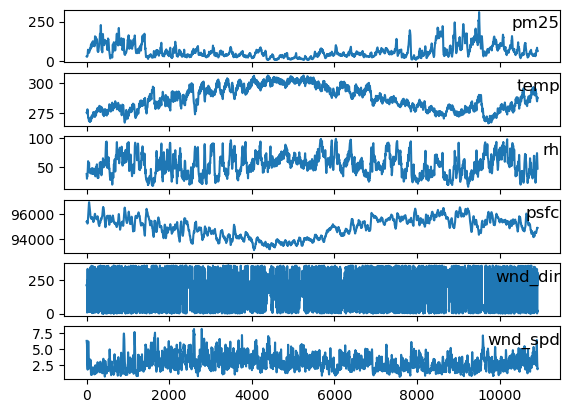

In [87]:
# 处理数据，我们使用一年+一个季度的数据=15个月 = 20130101-20140331 10920数据
multi_data = pd.read_csv('E:/vis23_xai_paper/code/Steerable-time-series-forecast/used_multi_data/weighted12_15month.csv')
print(multi_data['date'][10919])
multi_data.drop('date',axis=1,inplace=True)
multi_data.head()
# 对每列进行绘图，查看对应变量的变化
values = multi_data.values
groups = [0,1,2,3,4,5]
i = 1
plt.figure()
for group in groups:
    plt.subplot(len(groups),1,i)
    plt.plot(values[:,group])
    plt.title(multi_data.columns[group],y=0.5,loc='right')
    i += 1
plt.show()

In [26]:
# 将序列转换成监督式学习
def series_to_supervised(data, n_in, n_out, dropnan=True):  # nin对应往前多少天，nout对应往后多少天
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # 输入序列(t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # 预测序列 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # 将他们整合在一起
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

10885
the length of reframed after precessing:        var1(t-24)  var2(t-24)  var3(t-24)  var4(t-24)  var5(t-24)  var6(t-24)  \
24       0.077695    0.225752    0.267334    0.587656    0.544338    0.750081   
30       0.073934    0.214468    0.189239    0.599510    0.546220    0.694737   
36       0.083196    0.226783    0.220172    0.590275    0.186268    0.353042   
42       0.081542    0.290773    0.219274    0.554277    0.110175    0.271536   
48       0.111202    0.261877    0.290259    0.567463    0.914892    0.151373   
...           ...         ...         ...         ...         ...         ...   
10884    0.123983    0.600918    0.255237    0.383671    0.958585    0.333020   
10890    0.084509    0.698075    0.118040    0.364443    0.274249    0.297222   
10896    0.094201    0.701979    0.097391    0.368734    0.430100    0.435112   
10902    0.131551    0.650825    0.151040    0.362904    0.770732    0.305434   
10908    0.154385    0.626793    0.230790    0.360714    0.764

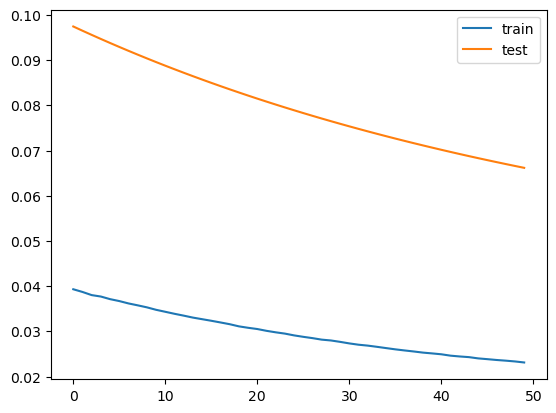

In [94]:
# 设置预测未来12小时的污染
# 设置预测未来12小时的污染
skip = 6 # 设置这里的skip

n_features = 6
train_len = 24
fore_len = 12

values = multi_data.values
# print('the dataset length:',len(values))

encoder  = preprocessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4]) # 对风向进行编码
# 确保都是float
values = values.astype('float32')

# 这里要对数据进行预处理，两个值使用不一样的scaler
s1 = MinMaxScaler(feature_range=(0,1)) # s1 是针对 pm25的编码方式
s2 = MinMaxScaler(feature_range=(0,1)) # s2 是其他五种的编码方式
# new_values1 = s1.fit_transform(multi_data['pm25'].values.reshape(-1,1))
# new_values2 = s2.fit_transform(multi_data[['temp','rh','psfc','wnd_dir','wnd_spd']].values)
value1 = s1.fit_transform(values[:,0].reshape(-1,1))
value2 = s2.fit_transform(values[:,1:6]) # 取出后面5列variable
new_values = np.append(value1, value2, axis=1)
# new_values.shape # 处理好的数据

# 时间序列数据转换为监督学习数据
reframed = series_to_supervised(new_values, train_len, fore_len) # data, nin, nout

# print('column names:', reframed.columns)
del_col = []
for i in range(0,fore_len):
  for j in range(1,6):
    tmp = (train_len + i) * 6 + j
    del_col.append(tmp)

reframed.drop(reframed.columns[del_col], axis = 1, inplace = True)
# print(reframed.head())
# print('the length of original reframed:', reframed)

# 根据skip来删除一些行：从0开始
sel_data_col = []
print(len(reframed))
for i in range(0,len(reframed),skip):
  sel_data_col.append(i)
reframed = reframed.iloc[sel_data_col]
print('the length of reframed after precessing:', reframed)

# split into train and test sets  
values = reframed.values
INDEX = int(len(values) * 0.8)

train = values[:INDEX,:]
test = values[INDEX:, :]    

# split into input and outputs
train_x, train_y = train[:, :-24],train[:, -12:] # 维度为对应的时间
test_x, test_y = test[:, :-24], test[:, -12:]
# reshape input to be 3D [samples, timesteps, features]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

# 创建模型
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.5))
model.add(LSTM(48)) 
model.add(Dense(12)) # 预测未来12h
sgd = optimizers.gradient_descent_v2.SGD(learning_rate = 0.001, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(loss='mean_squared_error', optimizer='sgd',metrics=['mean_absolute_percentage_error'],run_eagerly=True)
print(model.summary())

# 训练模型
history = model.fit(train_x, train_y, epochs=50, batch_size=256, validation_data=(test_x, test_y), verbose=2, shuffle=False) # used_epoch= 50
model.save('E:/vis23_xai_paper/code/Steerable-time-series-forecast/used_multi_data/weighted12_skip6.h5')

# # 对损失进行可视化
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [95]:
# 存储对应的结果文件：需要有的信息是 / predict_data, mse, rmse
predict_info = []
mse_info = []
rmse_info = []
smooth_info = []
skip_info = []
mape_info = []

print('reframed length:', len(reframed))
all_test_data = reframed.values
all_x = all_test_data[:,:-24]
all_y = all_test_data[:,-12:]

# reshape input to be 3D [samples, timesteps, features]
all_x = all_x.reshape((all_x.shape[0], 1, all_x.shape[1]))

print(all_x.shape, all_y.shape)

# 预测值
all_yhat = model.predict(all_x)
all_yhat = all_yhat.reshape(-1 ,12)
print('shape',all_yhat.shape)
all_used_x = all_x.reshape((all_x.shape[0], all_x.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((all_used_x, all_yhat),axis=1)
inv_yhat = s1.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, -12:]
print('forcast:',inv_yhat)
print('forecast len:',len(inv_yhat[0]))

# invert scaling for actual
inv_y = np.concatenate((all_used_x, all_y), axis=1)
inv_y = s1.inverse_transform(inv_y)
inv_y = inv_y[:, -12:]

# mse_info + rmse
for i in range(len(inv_yhat)):
  tmp_value = inv_yhat[i]
  predict_info.append(tmp_value)
  tmp_mse = mean_squared_error(inv_y[i], inv_yhat[i])
  tmp_rmse = math.sqrt(mean_squared_error(inv_y[i], inv_yhat[i]))
  mse_info.append(tmp_mse)
  rmse_info.append(tmp_rmse)
  smooth_info.append('raw')
  skip_info.append(skip)


# 指定要写入的文件名
file_name = 'E:/vis23_xai_paper/code/Steerable-time-series-forecast/used_multi_data/weighted12_skip6.csv'  # 这里记得要改文件名

print('len of results:',len(skip_info))

# 写入文件
info = pd.DataFrame()
info['predict_data'] = predict_info
info['mse'] = mse_info
info['rmse'] = rmse_info
info['smooth'] = smooth_info
info['skip'] = skip_info
info['mape'] = mape_info
info.to_csv(file_name,encoding="UTF-8")


reframed length: 1815
(1815, 1, 132) (1815, 12)
shape (1815, 12)
forcast: [[28.844261 27.37937  23.276257 ... 29.002823 28.462788 27.798471]
 [27.57874  27.660883 24.373457 ... 27.738363 27.24139  29.417006]
 [29.873798 28.612999 22.739721 ... 29.127714 26.91756  29.422436]
 ...
 [27.409622 25.17411  25.007076 ... 27.529676 30.209856 25.978676]
 [28.02096  24.222965 27.658295 ... 27.943985 29.672632 28.39334 ]
 [30.169617 25.71227  26.72256  ... 26.227722 28.146572 28.297   ]]
forecast len: 12
len of results: 1815


In [20]:
# 取数据，前10920的数据
raw_multi_data = pd.read_csv('E:/vis23_xai_paper/code/Steerable-time-series-forecast/multivar/multi_weighted12.csv')
new_multi_data = raw_multi_data.iloc[0:10920]
new_multi_data.to_csv('E:/vis23_xai_paper/code/Steerable-time-series-forecast/used_multi_data/weighted12_15month.csv')